Se creará una red completa, en ella se programará la dinámica combinada de Scatà et al.

Se creará una red completa con el mismo número de nodos por cada estrategia.
Cada nodo jugará el juego de la corrupción con los nodos restantes.

La dinámica debe recrear los resultados del modelo del replicador vistos en la sección 4.2

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots 
import os
from collections import Counter # Para contar estrategias fácilmente

# --- Parámetros del Juego de la Corrupción ---
# (Estos se pasarán a la función de simulación)

PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
#Parametros para el caso mexicano, p > q, s < q + d < p, q + d << p, 0 < c << 1
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones  ---

def crear_red_completa(n):
    """Crea una red completa con n nodos."""
    return nx.complete_graph(n)

def inicializar_estrategias_corrupcion(n, estrategias_map=None):
    """Inicializa las 4 estrategias (C, D, H, K) equitativamente."""
    if n % 4 != 0:
        print("Advertencia: El número de nodos no es divisible por 4. La distribución no será exactamente equitativa.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))
    random.shuffle(nodos) # Mezclar para asignación aleatoria si se prefiere, aunque aquí es secuencial

    idx = 0
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'
        idx += 1
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'
        idx += 1
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'
        idx += 1
    # Los restantes son K
    while idx < n:
         estrategias[nodos[idx]] = 'K'
         idx += 1

    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    """Calcula el pago para el jugador i contra el jugador j en el Juego de la Corrupción."""
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']

    payoffs = {
        # (Strat_i, Strat_j): Pago_i
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0) # Devuelve 0 si hay alguna combinación inesperada

def actualizar_estrategia_corrupcion(red, nodo, estrategias, recompensas_totales, K):
    """
    Actualiza la estrategia de un nodo utilizando la regla de Fermi,
    comparando su recompensa total con la de otro nodo elegido al azar.
    SIN HOMOFILIA.
    """
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    # Elegir OTRO nodo al azar (cualquiera en la red completa)
    posibles_vecinos = [n for n in red.nodes() if n != nodo]
    if not posibles_vecinos: # Si solo hay un nodo
         return estrategia_actual
    otro_nodo = random.choice(posibles_vecinos)

    estrategia_otro = estrategias[otro_nodo]
    recompensa_total_otro = recompensas_totales[otro_nodo]

    # Aplicar regla de Fermi (simplificada, sin homofilia)
    try:
        if K <= 1e-9: # Evitar división por cero o K muy pequeño
             probabilidad_adoptar = 1.0 if recompensa_total_otro > recompensa_total_actual else 0.0
        else:
            # Escalar diferencia para evitar overflow en exp()
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_otro) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
         # Si aún así hay error, adoptar la estrategia con mayor recompensa
        probabilidad_adoptar = 1.0 if recompensa_total_otro > recompensa_total_actual else 0.0


    if random.random() < probabilidad_adoptar:
        return estrategia_otro
    else:
        return estrategia_actual

def ejecutar_simulacion_corrupcion(
    num_nodos=0,
    params_juego=PARAMS_MEXICO, # Parámetros de la matriz de pagos
    K=0.0, # Nivel de ruido/incertidumbre en la adopción
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación del Juego de la Corrupción en una red completa.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"Creando red completa con {num_nodos} nodos...")
    red = crear_red_completa(num_nodos)
    print("Inicializando estrategias (C, D, H, K)...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos)

    # Diccionario para guardar la historia de las fracciones de cada estrategia
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes()) # Lista de nodos para eficiencia

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        # 1. Calcular recompensas totales para todos los nodos
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for i_idx, nodo_i in enumerate(nodos_lista):
            strat_i = estrategias[nodo_i]
            # Juega contra todos los demás
            for j_idx, nodo_j in enumerate(nodos_lista):
                if i_idx == j_idx:
                    continue # No juega contra sí mismo
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        # 2. Intentar actualizar estrategia para cada nodo (guardar en dict temporal)
        siguientes_estrategias = {}
        for nodo in nodos_lista:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion(
                red, nodo, estrategias, recompensas_totales, K
            )

        # 3. Aplicar las nuevas estrategias para la siguiente ronda
        estrategias = siguientes_estrategias

        # 4. Registrar fracción de cada estrategia
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            historia_fracciones[strat].append(conteo_actual.get(strat, 0) / num_nodos)

        # Opcional: Imprimir progreso cada X rondas
        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")
             # print(f"    Fracciones: C={historia_fracciones['C'][-1]:.2f}, D={historia_fracciones['D'][-1]:.2f}, H={historia_fracciones['H'][-1]:.2f}, K={historia_fracciones['K'][-1]:.2f}")


    print("Simulación completada.")
    return historia_fracciones

def graficar_evolucion_corrupcion(historia_fracciones, titulo, filename):
    """Grafica la evolución de las 4 estrategias a lo largo del tiempo."""
    plt.style.use(['science', 'ieee']) # Estilo de gráfica científica
    plt.figure(figsize=(3, 3)) # Tamaño ajustado para 4 líneas

    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'} # Colores distintivos
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'} # Estilos de línea distintivos
    nombres_legenda = {
        'C': 'Civiles cooperadores (C)',
        'D': 'Civiles no cooperadores (D)',
        'H': 'Poder Honrado (H)',
        'K': 'Poder Corrupto (K)'
    }


    rondas_totales = len(historia_fracciones['C']) # Asumiendo que todas tienen la misma longitud
    eje_x = range(rondas_totales)

    for strat in ['C', 'D', 'H', 'K']:
        plt.plot(
            eje_x,
            historia_fracciones[strat],
            label=nombres_legenda[strat],
            color=colores[strat],
            linestyle=estilos[strat]
        )

    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje")
    plt.title(f"Evolución del Juego de la Corrupción\n({titulo})")
    plt.ylim(0, 1) # Eje Y entre 0 y 1 (o 0 y 0.8/0.5 si prefieres como en tu tesis)
    plt.legend(fontsize='medium') # Leyenda más legible
    plt.grid(True, color="#EAEAEA")

    # Guardar la gráfica
    os.makedirs(os.path.dirname(filename), exist_ok=True) # Crear directorio si no existe
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"Gráfica de evolución guardada como '{filename}'")
    plt.close() # Cerrar la figura para liberar memoria


# --- Función Principal para Ejecutar y Graficar ---

def simular_y_graficar_pais(nombre_pais, params_juego, num_nodos, K, rondas, seed, output_dir="Resultados_Corrupcion"):
    """Ejecuta la simulación para un 'país' (conjunto de parámetros) y guarda la gráfica."""

    print(f"\n--- Iniciando simulación para {nombre_pais} ---")
    historia = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    nombre_archivo_grafica = os.path.join(output_dir, f"evolucion_{nombre_pais.lower().replace(' ', '_')}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, nombre_archivo_grafica)
    print(f"--- Simulación para {nombre_pais} completada ---")
    return historia

# --- Ejemplo de Uso ---

if __name__ == "__main__":
    # Parámetros globales de simulación
    NODOS = 400
    RUIDO_K = 0.00000 # Puedes experimentar con este valor, similar a Scatà et al. (K=0.5) o más bajo
    RONDAS = 15 # Ajusta según necesites para ver convergencia
    SEED_GLOBAL = 42 # Para reproducibilidad
    OUTPUT_DIR_GLOBAL = "Resultados_Juego_Corrupcion"

    # Ejecutar para cada país
    historia_dinamarca = simular_y_graficar_pais("Dinamarca", PARAMS_DINAMARCA, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)
    historia_singapur = simular_y_graficar_pais("Singapur", PARAMS_SINGAPUR, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)
    historia_mexico = simular_y_graficar_pais("México", PARAMS_MEXICO, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)

    print(f"\nTodas las simulaciones completadas. Resultados guardados en '{OUTPUT_DIR_GLOBAL}'.")

    # Opcional: Mostrar las gráficas si estás en un entorno como Jupyter
    try:
        from IPython.display import SVG, display
        print("\nMostrando gráficas generadas:")
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_dinamarca.svg")))
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_singapur.svg")))
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_mexico.svg")))
    except ImportError:
        print("\n(Instala IPython para ver las gráficas directamente aquí si estás en un notebook).")
    except Exception as e:
        print(f"\nNo se pudieron mostrar las gráficas: {e}")


--- Iniciando simulación para Dinamarca ---
Creando red completa con 400 nodos...
Inicializando estrategias (C, D, H, K)...
Iniciando 15 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Juego_Corrupcion\evolucion_dinamarca.svg'
--- Simulación para Dinamarca completada ---

--- Iniciando simulación para Singapur ---
Creando red completa con 400 nodos...
Inicializando estrategias (C, D, H, K)...
Iniciando 15 rondas de simulación...
Simulación completada.


# Se usan otro tipos de red, Barabási-Albert


--- Iniciando simulación para Dinamarca en red tipo 'Completa' ---
Creando red tipo 'Completa' con 100 nodos...
Red creada. Nodos: 100, Enlaces: 4950
Inicializando estrategias (C, D, H, K)...
Iniciando 16 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Juego_Corrupcion_Redes\Red_Completa\evolucion_dinamarca_Completa.svg'
--- Simulación para Dinamarca en red 'Completa' completada ---

--- Iniciando simulación para Singapur en red tipo 'Completa' ---
Creando red tipo 'Completa' con 100 nodos...
Red creada. Nodos: 100, Enlaces: 4950
Inicializando estrategias (C, D, H, K)...
Iniciando 16 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Juego_Corrupcion_Redes\Red_Completa\evolucion_singapur_Completa.svg'
--- Simulación para Singapur en red 'Completa' completada ---

--- Iniciando simulación para México en red tipo 'Completa' ---
Creando red tipo 'Completa' con 100 nodos...
Red creada. Nodos: 100, Enl

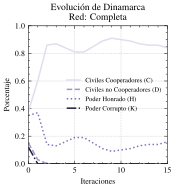


--- Singapur Completa{} ---


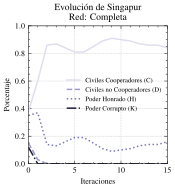


--- Mexico Completa{} ---


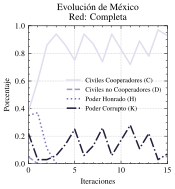


--- Dinamarca Barabási-Albert{'m': 2} ---


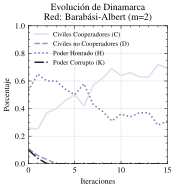


--- Singapur Barabási-Albert{'m': 2} ---


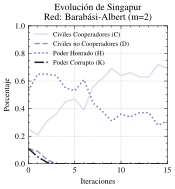


--- Mexico Barabási-Albert{'m': 2} ---


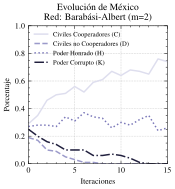


--- Dinamarca Barabási-Albert{'m': 4} ---


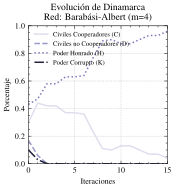


--- Singapur Barabási-Albert{'m': 4} ---


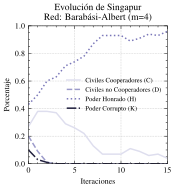


--- Mexico Barabási-Albert{'m': 4} ---


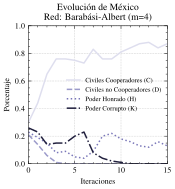

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros del Juego de la Corrupción (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (calcular_pago y inicializar_estrategias sin cambios) ---

def inicializar_estrategias_corrupcion(n, seed=None):
    """Inicializa las 4 estrategias (C, D, H, K) equitativamente."""
    if n % 4 != 0:
        print(f"Advertencia: Número de nodos ({n}) no divisible por 4. Distribución no será exacta.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))

    # Usar el generador aleatorio de Python para shuffle, inicializado con seed si se provee
    if seed is not None:
        random.seed(seed) # Afecta a random.shuffle
    random.shuffle(nodos)

    idx = 0
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n: # Asignar restantes a K
        estrategias[nodos[idx]] = 'K'; idx += 1

    # Ordenar por clave (nodo ID) para consistencia, aunque no estrictamente necesario
    estrategias = dict(sorted(estrategias.items()))
    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    """Calcula el pago para el jugador i contra el jugador j en el Juego de la Corrupción."""
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = {
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0)

# --- Funciones de Simulación Modificadas ---

def actualizar_estrategia_corrupcion_red(red, nodo, estrategias, recompensas_totales, K):
    """
    Actualiza la estrategia de un nodo utilizando la regla de Fermi,
    comparando su recompensa total con la de un VECINO elegido al azar.
    """
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    # Elegir un VECINO al azar
    vecinos = list(red.neighbors(nodo))
    if not vecinos: # Nodo aislado
         return estrategia_actual
    vecino_elegido = random.choice(vecinos) # <--- Cambio clave: elige entre vecinos

    estrategia_vecino = estrategias[vecino_elegido]
    recompensa_total_vecino = recompensas_totales[vecino_elegido]

    # Aplicar regla de Fermi
    try:
        if K <= 1e-9:
             probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else:
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
        probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0

    if random.random() < probabilidad_adoptar:
        return estrategia_vecino
    else:
        return estrategia_actual

def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='completa', # <--- Nuevo: 'completa', 'ba'
    network_params=None,     # <--- Nuevo: dict con params, e.g., {'m': 2} for ba
    params_juego=PARAMS_MEXICO,
    K=0.1,
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación del Juego de la Corrupción en el tipo de red especificado.
    Las interacciones (juego y actualización) ocurren entre vecinos.
    """
    if seed is not None:
        # Asegurar que la creación de la red y la dinámica aleatoria sean reproducibles
        random.seed(seed)
        np.random.seed(seed)
        # NetworkX usa el generador de NumPy para algunos modelos
        # Para otros como BA usa el global de Python (que ya inicializamos)

    # --- Creación de Red Dinámica ---
    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    if network_type == 'Completa':
        red = nx.complete_graph(num_nodos)
        network_params_str = "" # No necesita parámetros extra
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2) # Default m=2 para BA si no se especifica
        if m >= num_nodos:
             print(f"Advertencia: m ({m}) >= num_nodos ({num_nodos}). Usando m = {max(1, num_nodos // 2)}.")
             m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed) # Usa seed para BA
        network_params_str = f"_(m={m})" # Para nombres de archivo
    # Añadir aquí elif para 'ws', 'er', etc. si se desea
    # elif network_type == 'ws':
    #     if network_params is None: network_params = {}
    #     k_ws = network_params.get('k', 4)
    #     p_ws = network_params.get('p', 0.1)
    #     red = nx.watts_strogatz_graph(num_nodos, k_ws, p_ws, seed=seed)
    #     network_params_str = f"_k{k_ws}_p{p_ws:.1f}".replace('.', '')
    else:
        raise ValueError(f"Tipo de red desconocido: {network_type}")

    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")
    if not nx.is_connected(red):
         print("Advertencia: La red generada no está conectada.")
         # Podrías decidir tomar el componente gigante aquí si es necesario
         # O simplemente continuar, la dinámica solo ocurrirá dentro de componentes
    # --------------------------------

    print("Inicializando estrategias (C, D, H, K)...")
    # Pasar seed a inicialización para reproducibilidad del shuffle
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)

    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes())

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        # 1. Calcular recompensas totales (JUGANDO CON VECINOS)
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]
            vecinos_i = list(red.neighbors(nodo_i)) # <--- Cambio clave
            if not vecinos_i: continue # Saltar nodos aislados
            for nodo_j in vecinos_i: # <--- Iterar solo sobre vecinos
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        # 2. Actualizar estrategia (BASADO EN VECINOS)
        siguientes_estrategias = {}
        nodos_actualizar = nodos_lista[:] # Copiar lista para posible modificación
        random.shuffle(nodos_actualizar) # Actualizar en orden aleatorio cada ronda
        for nodo in nodos_actualizar:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red( # <--- Usar la función _red
                red, nodo, estrategias, recompensas_totales, K
            )
        estrategias = siguientes_estrategias

        # 3. Registrar fracción de cada estrategia
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            # Manejar caso donde num_nodos podría ser 0 si la red está vacía (improbable)
            fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0
            historia_fracciones[strat].append(fraccion)


        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")

    print("Simulación completada.")
    # Devolver también parámetros usados para el nombre de archivo
    return historia_fracciones, network_type, network_params_str

def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, filename):
    """Grafica la evolución de las 4 estrategias, añadiendo tipo de red al título."""
    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(2.5, 2.5)) # Ajustar tamaño si es necesario

    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}
    nombres_legenda = {
        'C': 'Civiles Cooperadores (C)', 'D': 'Civiles no Cooperadores (D)',
        'H': 'Poder Honrado (H)', 'K': 'Poder Corrupto (K)'
    } # Acortar leyendas

    rondas_totales = len(historia_fracciones['C'])
    eje_x = range(rondas_totales)

    for strat in ['C', 'D', 'H', 'K']:
        plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat],
                 color=colores[strat], linestyle=estilos[strat], linewidth=1.5) # Líneas un poco más gruesas

    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje")
    # Añadir tipo de red al título
    plt.title(f"Evolución de {titulo}\nRed: {network_type_str}")
    plt.ylim(0, 1.0) # Un poco más de margen superior
    plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1) # Ajustar límite x
    plt.legend(fontsize='small', loc='best') # Leyenda más pequeña, mejor ubicación
    plt.grid(True, linestyle='--', alpha=0.6) # Rejilla suave

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"Gráfica de evolución guardada como '{filename}'")
    plt.close()

# --- Función Principal para Ejecutar y Graficar (Modificada) ---

def simular_y_graficar_pais(
    nombre_pais,
    params_juego,
    num_nodos,
    network_type, # <--- Nuevo
    network_params, # <--- Nuevo
    K,
    rondas,
    seed,
    output_dir="Resultados_Corrupcion"
    ):
    """Ejecuta la simulación para un 'país' y tipo de red, guarda la gráfica."""

    print(f"\n--- Iniciando simulación para {nombre_pais} en red tipo '{network_type}' ---")
    historia, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        network_type=network_type, # Pasa el tipo de red
        network_params=network_params, # Pasa los parámetros de red
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    # Construir nombre de archivo incluyendo tipo de red y parámetros
    nombre_base = f"evolucion_{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}"
    nombre_archivo_grafica = os.path.join(output_dir, f"{nombre_base}.svg")

    # Pasar el string formateado de parámetros para el título
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, nombre_archivo_grafica)

    print(f"--- Simulación para {nombre_pais} en red '{network_type}' completada ---")
    return historia, nombre_archivo_grafica # Devolver path para display

# --- Ejemplo de Uso ---

if __name__ == "__main__":
    # Parámetros globales
    NODOS = 100
    RUIDO_K = 0.1 # Explorar valores, e.g., 0.01, 0.1, 0.5
    RONDAS = 16 # Aumentar para ver mejor convergencia
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = "Resultados_Juego_Corrupcion_Redes"

    # Definir tipos de red y parámetros a probar
    simulaciones_a_ejecutar = [
        {'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}}, # Barabasi-Albert con m=2
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 4}}, # Barabasi-Albert con m=4
        # {'network_type': 'ws', 'network_params': {'k': 4, 'p': 0.1}}, # Ejemplo Watts-Strogatz
    ]

    # Diccionario para guardar paths de las gráficas generadas
    graficas_generadas = {}

    for sim_config in simulaciones_a_ejecutar:
        net_type = sim_config['network_type']
        net_params = sim_config['network_params']

        # Crear subdirectorio por tipo de red
        output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{''.join([f'_{k}{v}' for k,v in net_params.items()])}")

        # Ejecutar para cada país con esta configuración de red
        graficas_generadas[f"Dinamarca_{net_type}{net_params}"] = simular_y_graficar_pais(
            "Dinamarca", PARAMS_DINAMARCA, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir
        )[1] # Guardar path
        graficas_generadas[f"Singapur_{net_type}{net_params}"] = simular_y_graficar_pais(
            "Singapur", PARAMS_SINGAPUR, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir
        )[1] # Guardar path
        graficas_generadas[f"Mexico_{net_type}{net_params}"] = simular_y_graficar_pais(
            "México", PARAMS_MEXICO, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir
        )[1] # Guardar path

    print(f"\nTodas las simulaciones completadas. Resultados guardados en subdirectorios dentro de '{OUTPUT_DIR_GLOBAL}'.")

    # Opcional: Mostrar las gráficas si estás en un entorno como Jupyter
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        for nombre, path_grafica in graficas_generadas.items():
             if os.path.exists(path_grafica):
                 print(f"\n--- {nombre.replace('_', ' ')} ---")
                 display(SVG(path_grafica))
             else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")
    else:
         print("\nNo se pudieron mostrar las gráficas.")

# Se grafican las redes creadas


--- Iniciando simulación para Dinamarca en red tipo 'Completa' ---
Creando red tipo 'Completa' con 300 nodos...
Red creada. Nodos: 300, Enlaces: 44850
Inicializando estrategias (C, D, H, K)...
Iniciando 15 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Modelo_refinado_Scatà_et_al\Red_Completa\evolucion_dinamarca_Completa.svg'
--- Simulación para Dinamarca en red 'Completa' completada ---

--- Iniciando simulación para Singapur en red tipo 'Completa' ---
Creando red tipo 'Completa' con 300 nodos...
Red creada. Nodos: 300, Enlaces: 44850
Inicializando estrategias (C, D, H, K)...
Iniciando 15 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Modelo_refinado_Scatà_et_al\Red_Completa\evolucion_singapur_Completa.svg'
--- Simulación para Singapur en red 'Completa' completada ---

--- Iniciando simulación para México en red tipo 'Completa' ---
Creando red tipo 'Completa' con 300 nodos...
Red creada. Nod

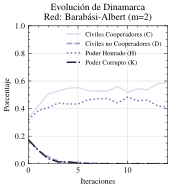


--- Dinamarca_BA_m2 Red ---


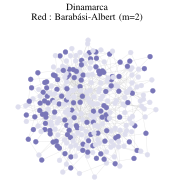


--- Dinamarca_BA_m4 Evolución ---


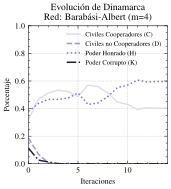


--- Dinamarca_BA_m4 Red ---


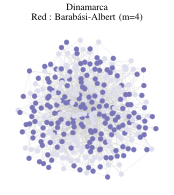


--- Dinamarca_Completa Evolución ---


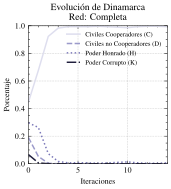


--- México_BA_m2 Evolución ---


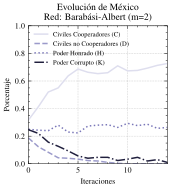


--- México_BA_m2 Red ---


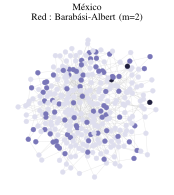


--- México_BA_m4 Evolución ---


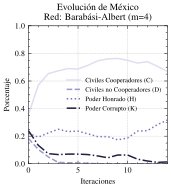


--- México_BA_m4 Red ---


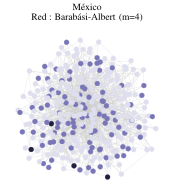


--- México_Completa Evolución ---


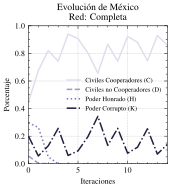


--- Singapur_BA_m2 Evolución ---


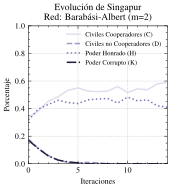


--- Singapur_BA_m2 Red ---


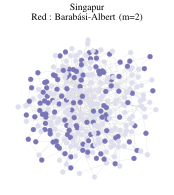


--- Singapur_BA_m4 Evolución ---


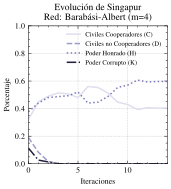


--- Singapur_BA_m4 Red ---


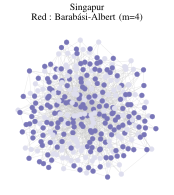


--- Singapur_Completa Evolución ---


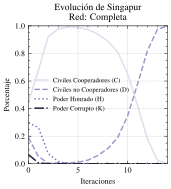

In [3]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display
except ImportError:
    SVG, display = None, None

# --- Parámetros del Juego de la Corrupción (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# --- Funciones Auxiliares (sin cambios) ---
def inicializar_estrategias_corrupcion(n, seed=None):
    
    if n % 4 != 0:
        print(f"Advertencia: Número de nodos ({n}) no divisible por 4. Distribución no será exacta.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))

    if seed is not None:
        random.seed(seed)
    random.shuffle(nodos)

    idx = 0
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'; idx += 1
    for _ in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'; idx += 1
    while idx < n:
        estrategias[nodos[idx]] = 'K'; idx += 1

    estrategias = dict(sorted(estrategias.items()))
    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    # ... (código igual que antes) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = {
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red(red, nodo, estrategias, recompensas_totales, K):
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    vecinos = list(red.neighbors(nodo))
    if not vecinos:
         return estrategia_actual
    vecino_elegido = random.choice(vecinos)

    estrategia_vecino = estrategias[vecino_elegido]
    recompensa_total_vecino = recompensas_totales[vecino_elegido]

    try:
        if K <= 1e-9:
             probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else:
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
        probabilidad_adoptar = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0

    if random.random() < probabilidad_adoptar:
        return estrategia_vecino
    else:
        return estrategia_actual


# --- Ejecución de Simulación (Modificada para devolver red y estrategias finales) ---
def ejecutar_simulacion_corrupcion(
    num_nodos=100,
    network_type='Completa', 
    network_params=None,
    params_juego=PARAMS_MEXICO,
    K=0.1,
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación.
    Devuelve: historia_fracciones, red, estrategias_finales, network_type, network_params_str
    """
    # ... (inicialización de seed y creación de red) ...
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"Creando red tipo '{network_type}' con {num_nodos} nodos...")
    network_params_str_out = "" # String para nombres de archivo
    if network_type == 'Completa':
        red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos:
             print(f"Advertencia: m ({m}) >= num_nodos ({num_nodos}). Usando m = {max(1, num_nodos // 2)}.")
             m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed)
        network_params_str_out = f"_(m={m})"
    else:
        raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada. Nodos: {red.number_of_nodes()}, Enlaces: {red.number_of_edges()}")
    # ... (resto del código: inicializar estrategias, bucle de simulación) ...
    print("Inicializando estrategias (C, D, H, K)...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos, seed=seed)

    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes())

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]
            vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i:
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        siguientes_estrategias = {}
        nodos_actualizar = nodos_lista[:]
        random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red(
                red, nodo, estrategias, recompensas_totales, K
            )
        estrategias = siguientes_estrategias # 'estrategias' ahora contiene las finales de esta ronda

        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            fraccion = conteo_actual.get(strat, 0) / num_nodos if num_nodos > 0 else 0
            historia_fracciones[strat].append(fraccion)

        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")

    print("Simulación completada.")
    # Devolver red y estrategias finales junto con la historia
    return historia_fracciones, red, estrategias, network_type, network_params_str_out

# --- Nueva Función para Graficar Redes BA ---
def graficar_red_final_ba(red, estrategias_finales, titulo, network_params_str, filename):
    """Grafica específicamente la red Barabási-Albert final."""
    if not isinstance(red, nx.Graph) or not red.nodes():
         print(f"Error: No se puede graficar red inválida para {titulo}.")
         return

    plt.style.use(['science', 'ieee'])
    plt.figure(figsize=(3, 3)) # Tamaño razonable para 100 nodos BA

    n = red.number_of_nodes()
    m_param = network_params_str # Extraer m si es necesario (requiere parsing o pasarlo)

    # Colores (los mismos que en la gráfica de evolución)
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]

    # Usar layout spring, es adecuado para BA
    print(f"  Calculando layout para red BA ({n} nodos)...")
    pos = nx.spring_layout(red, seed=42, k=0.5/np.sqrt(n)) # Ajustar k puede ayudar

    print(f"  Dibujando red final BA...")
    nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=25, linewidths=0.3, edgecolors='face')
    nx.draw_networkx_edges(red, pos, edge_color="#cccccc", alpha=0.4, width=0.5)

    plt.title(f"{titulo}\nRed : Barabási-Albert{m_param}")
    plt.axis('off')

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de red BA final guardada como '{filename}'")
    plt.close()


# --- Función Principal Modificada ---
def simular_y_graficar_pais(
    nombre_pais,
    params_juego,
    num_nodos,
    network_type,
    network_params,
    K,
    rondas,
    seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes_ba=True # Controlar si se grafica la red BA
    ):
    """
    Ejecuta la simulación y guarda las gráficas (evolución y red BA si aplica).
    """
    print(f"\n--- Iniciando simulación para {nombre_pais} en red tipo '{network_type}' ---")
    # Ahora devuelve 5 elementos
    historia, red_final, estrategias_finales, net_type_used, net_params_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        network_type=network_type,
        network_params=network_params,
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    # Construir nombre base para archivos
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str}"

    # Graficar evolución (siempre)
    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    network_title_str = f"{net_type_used}{net_params_str.replace('_', ' ')}"
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, path_grafica_evolucion)

    # Graficar red BA final (solo si es BA y se solicita)
    path_grafica_red = None # Inicializar path
    if net_type_used == 'Barabási-Albert' and graficar_redes_ba:
        path_grafica_red = os.path.join(output_dir, f"red_final_{nombre_base}.svg")
        graficar_red_final_ba(
            red_final,
            estrategias_finales,
            nombre_pais,
            net_params_str, # Pasar parámetros formateados
            path_grafica_red
        )

    print(f"--- Simulación para {nombre_pais} en red '{network_type}' completada ---")
    # Devolver paths para display
    return path_grafica_evolucion, path_grafica_red


# --- Ejemplo de Uso Modificado ---
if __name__ == "__main__":
    # Parámetros globales
    NODOS = 300
    RUIDO_K = 0.1
    RONDAS = 15 # <-- Aumentado para dar tiempo a evolucionar
    SEED_GLOBAL = 42
    OUTPUT_DIR_GLOBAL = "Resultados_Modelo_refinado_Scatà_et_al"
    GRAFICAR_REDES = True # <-- Control global para graficar redes (solo BA)

    simulaciones_a_ejecutar = [
        {'network_type': 'Completa', 'network_params': {}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 2}},
        {'network_type': 'Barabási-Albert', 'network_params': {'m': 4}},
    ]

    # Diccionario para guardar paths de TODAS las gráficas generadas
    paths_graficas = {}

    for sim_config in simulaciones_a_ejecutar:
        net_type = sim_config['network_type']
        net_params = sim_config['network_params']
        net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""


        # Crear subdirectorio por tipo de red
        output_subdir = os.path.join(OUTPUT_DIR_GLOBAL, f"Red_{net_type}{net_params_str_dir}")

        # Clave base para el diccionario de paths
        clave_base = f"{net_type}{net_params_str_dir}"

        # Ejecutar para cada país
        for pais, params in [("Dinamarca", PARAMS_DINAMARCA), ("Singapur", PARAMS_SINGAPUR), ("México", PARAMS_MEXICO)]:
             path_evol, path_red = simular_y_graficar_pais(
                 pais, params, NODOS, net_type, net_params, RUIDO_K, RONDAS, SEED_GLOBAL, output_subdir,
                 graficar_redes_ba=GRAFICAR_REDES # Pasar el control global
             )
             paths_graficas[f"{pais}_{clave_base}_evol"] = path_evol
             if path_red: # Guardar solo si se generó
                 paths_graficas[f"{pais}_{clave_base}_red"] = path_red


    print(f"\nTodas las simulaciones completadas. Resultados guardados en subdirectorios dentro de '{OUTPUT_DIR_GLOBAL}'.")

    # Mostrar las gráficas si es posible
    if display and SVG:
        print("\nMostrando gráficas generadas:")
        # Ordenar un poco para mostrar evolución y red juntas
        claves_ordenadas = sorted(paths_graficas.keys())
        for clave in claves_ordenadas:
            path_grafica = paths_graficas[clave]
            if os.path.exists(path_grafica):
                 # Limpiar nombre para display
                 nombre_display = clave.replace('_evol', ' Evolución').replace('_red', ' Red')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA') # Acortar
                 print(f"\n--- {nombre_display} ---")
                 display(SVG(path_grafica))
            else:
                 print(f"Archivo no encontrado: {path_grafica}")
    elif display is None or SVG is None:
        print("\n(Instala IPython/Jupyter para ver las gráficas directamente aquí).")